In [1]:
import model.mat as MAT
import os
from glob import glob
import model.aotgan 
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset
import random
import numpy as np
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
from loss1 import loss as loss_module
from torch_utils import misc
import copy
from torch_utils.ops import conv2d_gradfix
from losses.pcp import PerceptualLoss
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [ ]:
params={'image_size':512,
        'rates':[1, 2, 4, 8],
        'block_num':8,
        'model':'aotgan',
        'gan_type':"smgan",
        'lrg':2e-3,
        'lrd':2e-3,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':4,
        'epochs':1000,
        'data_path':'../../data/dataset/colon/',
        'num_workers':4,
        'rec_loss':'1*L1+100*Style+0.1*Perceptual'
        }
losses = list(params['rec_loss'].split("+"))
params['rec_loss'] = {}
for l in losses:
    weight, name = l.split("*")
    params['rec_loss'][name] = float(weight)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, args,dataset):
        super(Dataset, self).__init__()
        self.w = self.h = args['image_size']

        # image and mask
        self.image_path =glob(args['data_path']+dataset+'/image/*.png')
        self.mask_path = [i.replace('/image','/mask') for i in self.image_path]
        self.trans_1 = transforms.Compose(
            [
                transforms.Resize((args['image_size'],args['image_size']), interpolation=transforms.InterpolationMode.NEAREST)
            ]
        )
    def trans(self,image_t,a):
        image_t=F.to_tensor(F.rotate(self.trans_1(image_t),a))
        return image_t

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        # load image
        image = Image.open(self.image_path[index]).convert("RGB")
        filename = os.path.basename(self.image_path[index])
        mask = Image.open(self.mask_path[index])
        mask = mask.convert("L")
        # augment
        angle=random.randint(0, 360)
        
        image = self.trans(image,angle) * 2.0 - 1.0
        mask = self.trans(mask,angle)
        
        return image, mask, filename
    
train_dataset=CustomDataset(params,'train')
test_dataset=CustomDataset(params,'test')
train_dataloader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
         shuffle=True, drop_last=True)
test_dataloader = DataLoader(
        test_dataset,
        batch_size=params['batch_size'],
         shuffle=True, drop_last=True)

In [ ]:

netG = MAT.Generator(z_dim=256, c_dim=0, w_dim=512, img_resolution=512, img_channels=3).to(device)
netD = MAT.Discriminator(c_dim=0, img_resolution=params['image_size'], img_channels=3).to(device)
optimG = torch.optim.Adam(netG.parameters(), lr=params['lrg'], betas=(params['beta1'], params['beta2']))
optimD = torch.optim.Adam(netD.parameters(), lr=params['lrd'], betas=(params['beta1'], params['beta2']))
G_ema = copy.deepcopy(netG).eval()
G_mapping=netG.mapping
truncation_psi=1
style_mixing_prob=0.9
G_synthesis=netG.synthesis
pcp = PerceptualLoss(layer_weights=dict(conv4_4=1/4, conv5_4=1/2)).to(device)
def run_G(img_in, mask_in, z, c, sync):
    with misc.ddp_sync(G_mapping, sync):
        ws = G_mapping(z, c, truncation_psi=truncation_psi)
        if style_mixing_prob > 0:
            with torch.autograd.profiler.record_function('style_mixing'):
                cutoff = torch.empty([], dtype=torch.int64, device=ws.device).random_(1, ws.shape[1])
                cutoff = torch.where(torch.rand([], device=ws.device) < style_mixing_prob, cutoff, torch.full_like(cutoff, ws.shape[1]))
                ws[:, cutoff:] = G_mapping(torch.randn_like(z), c, truncation_psi=truncation_psi, skip_w_avg_update=True)[:, cutoff:]
    with misc.ddp_sync(G_synthesis, sync):
        img, img_stg1 = G_synthesis(img_in, mask_in, ws, return_stg1=True)
    return img, ws, img_stg1

def run_D(img, mask, img_stg1, c, sync):
    # if augment_pipe is not None:
    #     # img = augment_pipe(img)
    #     # !!!!! have to remove the color transform
    #     tmp_img = torch.cat([img, mask], dim=1)
    #     tmp_img = augment_pipe(tmp_img)
    #     img, mask = torch.split(tmp_img, [3, 1])
    with misc.ddp_sync(netD, sync):
        logits, logits_stg1 = netD(img, mask, img_stg1, c)
    return logits, logits_stg1

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/100 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


epoch: 1/1000 Step: 101 D loss : 2.1411 G loss: 2.3693 Dr loss: 0.6623 : 100%|██████████| 100/100 [02:22<00:00,  1.42s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


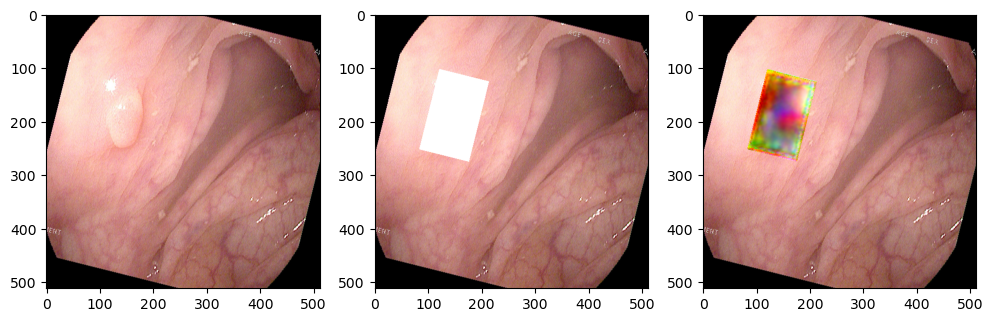

epoch: 2/1000 Step: 101 D loss : 1.8894 G loss: 1.4490 Dr loss: 0.4729 : 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]
epoch: 3/1000 Step: 11 D loss : 1.8095 G loss: 1.3867 Dr loss: 0.4340 :  10%|█         | 10/100 [00:14<02:08,  1.43s/it]


KeyboardInterrupt: 

In [ ]:


for epoch in range(params['epochs']):
    train=tqdm(train_dataloader)
    count=0
    train_Dgen_loss = 0.0 #예측된 값과 실제 값 사이의 절대값 차이의 평균 계산
    train_Ggen_loss = 0.0 # 네트워크가 생성한 이미지가 목표 스타일 이미지와 비슷한 텍스처, 색상 분포 및 시각적 패턴 비교
    train_Dr_loss = 0.0 
    
    sum_loss= 1000.0
    for images, masks,filename in train:
        count+=1
        images, masks = (images-0.5).to(device), masks.to(device)
        z = torch.randn(params['batch_size'], 256).to(device)
        masks=1-masks
        images_masked = (images * (masks).float()) + (1-masks)
        gen_img, _gen_ws, gen_img_stg1 = run_G(images, masks,z, None, sync=True) # May get synced by Gpl.
        gen_logits, gen_logits_stg1 = run_D(images, masks, gen_img_stg1,None, sync=False)
        
        # dis_loss, gen_loss = adv_loss(netD, comp_img, images, masks)
        # losses["advg"] = gen_loss
        # # backforward
        optimG.zero_grad()
        optimD.zero_grad()
        loss_Gmain = torch.nn.functional.softplus(-gen_logits)
        loss_Gmain_stg1 = torch.nn.functional.softplus(-gen_logits_stg1)
        pcp_loss, _ = pcp(gen_img, images)
        loss_Gmain_all = loss_Gmain + loss_Gmain_stg1 + pcp_loss
        loss_Gmain_all.mean().mul(1).backward()      
        # losses["advd"] = dis_loss
        # dis_loss.backward()
        loss_Dgen_stg1 = torch.nn.functional.softplus(gen_logits_stg1)
        loss_Dgen = torch.nn.functional.softplus(gen_logits) # -log(1 - sigmoid(gen_logits))
        loss_Dgen_all = loss_Dgen + loss_Dgen_stg1
        loss_Dgen_all.mean().mul(1).backward()
 
        
        real_img_tmp = images.detach().requires_grad_(True)
        mask_tmp = masks.detach().requires_grad_(True)
        real_img_tmp_stg1 = images.detach().requires_grad_(True)
        real_logits, real_logits_stg1 = run_D(real_img_tmp, mask_tmp, real_img_tmp_stg1, None, sync=True)
        loss_Dreal = torch.nn.functional.softplus(-real_logits) # -log(sigmoid(real_logits))
        loss_Dreal_stg1 = torch.nn.functional.softplus(-real_logits_stg1)  # -log(sigmoid(real_logits))
        with torch.autograd.profiler.record_function('r1_grads'), conv2d_gradfix.no_weight_gradients():
            r1_grads = torch.autograd.grad(outputs=[real_logits.sum()], inputs=[real_img_tmp], create_graph=True, only_inputs=True)[0]
            r1_grads_stg1 = torch.autograd.grad(outputs=[real_logits_stg1.sum()], inputs=[real_img_tmp_stg1], create_graph=True, only_inputs=True)[0]
        r1_penalty = r1_grads.square().sum([1,2,3])
        loss_Dr1 = r1_penalty * 5
        r1_penalty_stg1 = r1_grads_stg1.square().sum([1, 2, 3])
        loss_Dr1_stg1 = r1_penalty_stg1 * 5
        ((real_logits + real_logits_stg1) * 0 + loss_Dreal + loss_Dreal_stg1 + loss_Dr1 + loss_Dr1_stg1).mean().mul(1).backward()
        optimG.step()
        optimD.step()
        
        train_Dgen_loss+=loss_Dgen_all.mean().mul(1).item()
        train_Ggen_loss+=loss_Gmain_all.mean().mul(1).item()
        train_Dr_loss+=((real_logits + real_logits_stg1) * 0 + loss_Dreal + loss_Dreal_stg1 + loss_Dr1 + loss_Dr1_stg1).mean().mul(1).item()
        train.set_description(f"epoch: {epoch+1}/{params['epochs']} Step: {count+1} D loss : {train_Dgen_loss/count:.4f} G loss: {train_Ggen_loss/count:.4f} Dr loss: {train_Dr_loss/count:.4f} ")
    if epoch % 10 ==0:
        ax=plt.figure(figsize=(12,4))
        ax.add_subplot(1,3,1)
        plt.imshow(np.transpose((images[0]+0.5).cpu().detach().numpy(),(1,2,0))/2+0.5)
        ax.add_subplot(1,3,2)
        plt.imshow(np.transpose((images_masked[0]+0.5).cpu().detach().numpy(),(1,2,0))/2+0.5)
        ax.add_subplot(1,3,3)
        plt.imshow(np.transpose((gen_img[0]+0.5).cpu().detach().numpy(),(1,2,0))/2+0.5)

        plt.show()
        
    if sum_loss>(train_Dgen_loss/count+train_Ggen_loss/count):
        sum_loss=train_Dgen_loss/count+train_Ggen_loss/count
        torch.save(netG.state_dict(), '../../model/MAT_colon/generator_check.pt')
        torch.save(netD.state_dict(), '../../model/MAT_colon/discriminator_check.pt')   
torch.save(netG.state_dict(), '../../model/MAT_colon/generator.pt')
torch.save(netD.state_dict(), '../../model/MAT_colon/discriminator.pt')   